In [14]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [15]:
import pickle
BASE_PATH = "/kaggle/input/cifar-10-and-cifar-10-c/cifar-10-python/cifar-10-batches-py"

train_data = []
train_label = []

def unpickle(file):
    with open(file ,'rb') as f:
        data_dict = pickle.load(f , encoding = 'bytes')
    return data_dict
        
for i in range(1,6):
    batch_path = os.path.join(BASE_PATH , f"data_batch_{i}" )
    batch = unpickle(batch_path)
    train_data.append(batch[b'data'])
    train_label.extend(batch[b'labels'])

X_train = np.vstack(train_data)      
y_train = np.array(train_label)     

In [16]:
test_data = []
test_label = []

test_path = os.path.join(BASE_PATH , 'test_batch')
test_batch = unpickle(test_path)
test_data.append(test_batch[b'data'])
test_label.extend(test_batch[b'labels'])

y_test = np.array(test_label)    

In [17]:
CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD  = (0.2470, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),         
    transforms.RandomHorizontalFlip(p=0.5),        
    transforms.ColorJitter(brightness=0.1, contrast=0.1,
                           saturation=0.1, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

In [18]:
def cifar_flat_to_pil(img_flat):
    r = img_flat[0:1024].reshape(32,32)
    g = img_flat[1024:2048].reshape(32,32)
    b = img_flat[2048:3072].reshape(32,32)
    img = np.stack([r,g,b], axis=2).astype('uint8')
    pil_img = Image.fromarray(img).convert("RGB")
    return pil_img

In [19]:
from PIL import Image
def cifar_dataset_to_pil(flat_images):
    pil_images = []
    for img_flat in flat_images:
        pil_img = cifar_flat_to_pil(img_flat)  # pass the array directly
        pil_images.append(pil_img)
    return pil_images

train_data_flat = np.vstack(train_data)
test_data_flat = np.vstack(test_data)   

train_images = cifar_dataset_to_pil(train_data_flat)
test_images = cifar_dataset_to_pil(test_data_flat)

In [20]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import multiprocessing

class CIFAR10_dataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.has_labels = labels is not None
        print(f"\nLoading CIFAR10 Dataset... Total Len: {len(images)} | Labeled: {self.has_labels}\n{'-'*50}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        if self.has_labels:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return {"img": img, "label": label}
        else:
            return {"img": img}


train_images_split, val_images, y_train_split, y_val = train_test_split(
    train_images, y_train,
    test_size=0.2,         
    random_state=42,       
    stratify=y_train        
)

In [21]:
train_dataset = CIFAR10_dataset(train_images_split, y_train_split, transform=train_transform)
val_dataset = CIFAR10_dataset(val_images, y_val, transform=test_transform)
test_dataset = CIFAR10_dataset(test_images, labels=None, transform=test_transform)

batch_size = 128 # 128 per GPU if 2 GPUs
num_workers = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)



Loading CIFAR10 Dataset... Total Len: 40000 | Labeled: True
--------------------------------------------------

Loading CIFAR10 Dataset... Total Len: 10000 | Labeled: True
--------------------------------------------------

Loading CIFAR10 Dataset... Total Len: 10000 | Labeled: False
--------------------------------------------------


In [22]:
def create_model(model_name, num_classes=10):
    if model_name == 'ResNet18':
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'EfficientNet-B0':
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == 'VGG16':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(4096, num_classes)
    
    return model

In [23]:
model_configs = {
    "ResNet18": {
        "optimizer": "SGD",
        "lr": 0.01,
        "momentum": 0.8,
        "weight_decay": 5e-4
    },
    "EfficientNet-B0": {
        "optimizer": "AdamW",
        "lr": 0.001,
        "weight_decay": 1e-4
    },
    "VGG16": {
        "optimizer": "AdamW",
        "lr": 0.0005,
        "momentum": 0.9,
        "weight_decay": 5e-4
    }
}


In [24]:
import os

os.makedirs("/kaggle/working/model_results", exist_ok=True)

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import os
import numpy as np

def train_model(model, model_name, train_loader, val_loader, epochs=50):
    print(f"Training {model_name}")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # ===== MULTI-GPU SUPPORT =====
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs with DataParallel!")
        model = nn.DataParallel(model)
    model = model.to(device)

    # ===== MIXED PRECISION SETUP =====
    scaler = GradScaler()

    # ===== OPTIMIZER SETUP =====
    config = model_configs[model_name]
    if config['optimizer'] == 'SGD':
        optimizer = optim.SGD(
            model.parameters(),
            lr=config['lr'],
            weight_decay=1e-4,
            momentum=config.get('momentum', 0.8)
        )
    else:
        optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=1e-4)

    criterion = nn.CrossEntropyLoss()
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.1, patience=5, min_lr=1e-5
    )

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    best_val_acc = 0
    best_model_path = f"/kaggle/working/model_results/best_{model_name.replace('-', '_')}.pth"

    for epoch in range(epochs):
        # ===== TRAINING PHASE =====
        model.train()
        train_loss, train_correct = 0.0, 0

        for batch in tqdm(train_loader, desc=f'{model_name} - Epoch {epoch+1}/{epochs} [Train]'):
            images, labels = batch["img"].to(device), batch["label"].to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            train_correct += (preds == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # ===== VALIDATION PHASE =====
        model.eval()
        val_loss, val_correct = 0.0, 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f'{model_name} - Epoch {epoch+1}/{epochs} [Val]'):
                images, labels = batch["img"].to(device), batch["label"].to(device)

                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                preds = outputs.argmax(1)
                val_correct += (preds == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)

        # ===== LOGGING =====
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"\n{model_name} - Epoch {epoch+1}/{epochs}")
        print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"   Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

        # ===== SAVE BEST MODEL =====
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"NEW BEST MODEL! Val Acc: {val_acc:.2f}%")

        lr_scheduler.step(val_loss)

    print(f"\n {model_name} Training Complete! Best Val Acc: {best_val_acc:.2f}%")
    return history, best_val_acc


In [26]:
import numpy as np
import cv2
# ----------------------
# Gaussian Noise
# ----------------------
def add_gaussian_noise_np(img, sigma):
    noise = np.random.normal(0, sigma, img.shape)
    noisy_img = img + noise
    return np.clip(noisy_img, 0, 255).astype(np.uint8)

# ----------------------
# Gaussian Blur
# ----------------------
def gaussian_blur_np(img, sigma):
    ksize = max(1, int(6*sigma+1) | 1)
    blurred = cv2.GaussianBlur(img, (ksize, ksize), sigmaX=sigma)
    return blurred

# ----------------------
# Color Shift (Hue/Saturation)
# ----------------------
def color_shift_np(img, hue_shift_deg=0, sat_shift=0.0):
    hsv = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2HSV).astype(np.float32)
    hsv[...,0] = (hsv[...,0] + hue_shift_deg) % 180
    hsv[...,1] = np.clip(hsv[...,1] + sat_shift*255, 0, 255)
    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

In [27]:
import random
import math
corruption_appliers = {
    "gaussian_noise": lambda im, lvl: add_gaussian_noise_np(im, sigma=lvl),
    "gaussian_blur": lambda im, lvl: gaussian_blur_np(im, sigma=lvl),
    "color_shift": lambda im, lvl: color_shift_np(im, hue_shift_deg=int(lvl[0]), sat_shift=float(lvl[1]))
}

corruption_params = {
    "gaussian_noise": [0, 5, 15, 60],
    "gaussian_blur": [0, 1, 2, 4],
    "color_shift": [(0,0), (10,0.1), (20,0.2), (30,0.3), (40,0.4)]
}

In [30]:
model_names = ['ResNet18', 'VGG16', 'EfficientNet-B0']

In [43]:
def apply_corruption(img_batch, corruption_name, level):
    corrupted_batch = []
    level = float(level)

    for img in img_batch:
        if not isinstance(img, np.ndarray):
            img = np.array(img)
        if img.dtype != np.uint8:
            img = img.astype(np.uint8)
        
        if corruption_name == 'gaussian_noise':
            corrupted_img = add_gaussian_noise_np(img, sigma=level)
        elif corruption_name == 'gaussian_blur':
            corrupted_img = gaussian_blur_np(img, sigma=level)
        elif corruption_name == 'color_shift':
            corrupted_img = color_shift_np(img, hue_shift_deg=int(level*10), sat_shift=level*0.1)
        else:
            raise ValueError(f"Unknown corruption {corruption_name}")
        
        corrupted_batch.append(corrupted_img)
    
    return np.array(corrupted_batch, dtype=np.uint8)


=== Evaluating VGG16 on TEST set ===

Running corruption: gaussian_noise


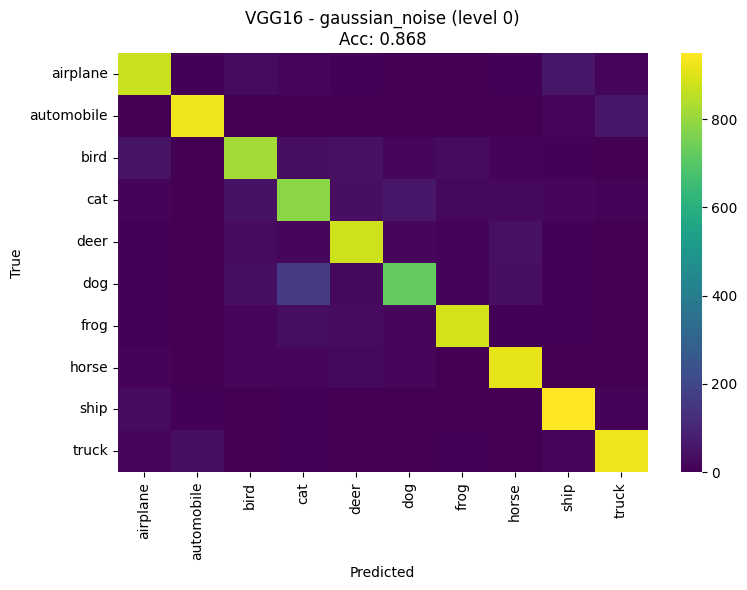

airplane: F1 = 0.870
automobile: F1 = 0.936
bird: F1 = 0.823
cat: F1 = 0.756
deer: F1 = 0.866
dog: F1 = 0.785
frog: F1 = 0.903
horse: F1 = 0.898
ship: F1 = 0.920
truck: F1 = 0.918


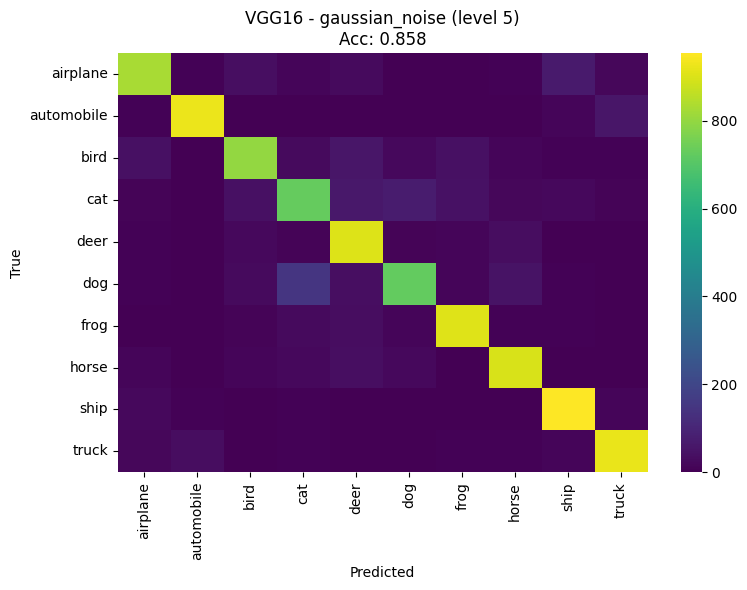

airplane: F1 = 0.852
automobile: F1 = 0.936
bird: F1 = 0.821
cat: F1 = 0.735
deer: F1 = 0.841
dog: F1 = 0.780
frog: F1 = 0.895
horse: F1 = 0.886
ship: F1 = 0.915
truck: F1 = 0.910


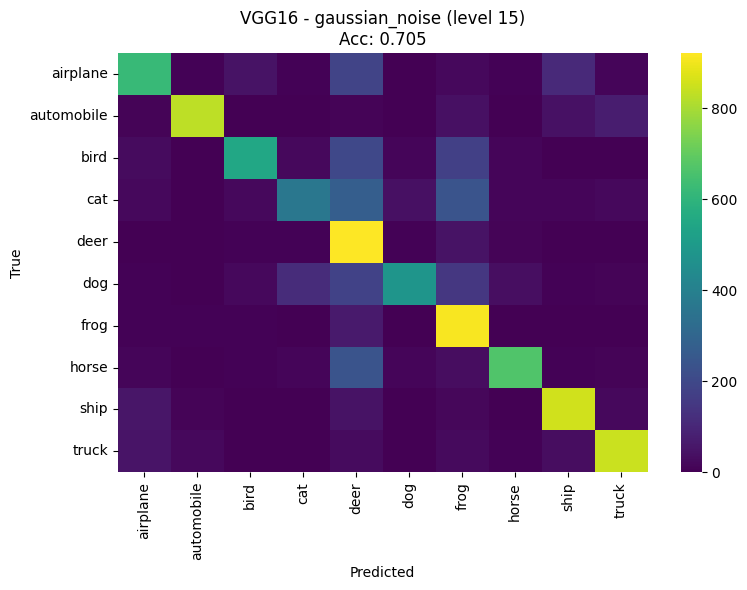

airplane: F1 = 0.687
automobile: F1 = 0.887
bird: F1 = 0.663
cat: F1 = 0.477
deer: F1 = 0.586
dog: F1 = 0.619
frog: F1 = 0.692
horse: F1 = 0.763
ship: F1 = 0.828
truck: F1 = 0.847


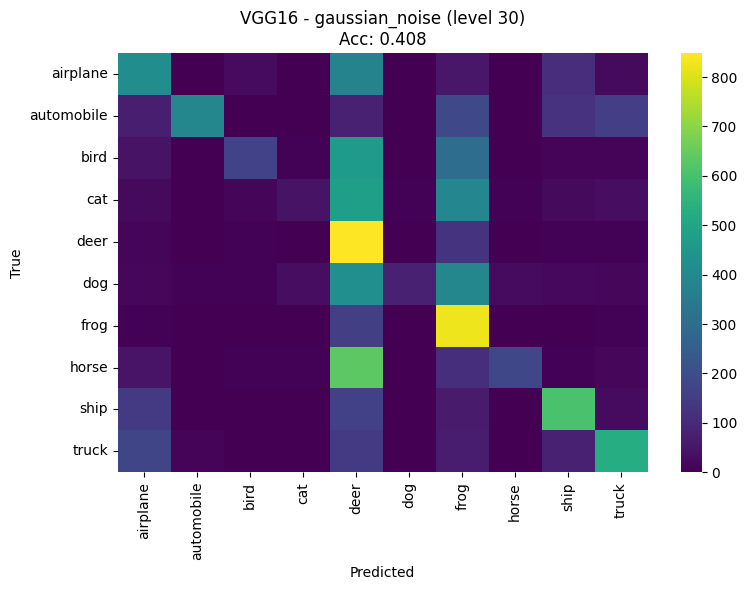

airplane: F1 = 0.428
automobile: F1 = 0.552
bird: F1 = 0.275
cat: F1 = 0.076
deer: F1 = 0.356
dog: F1 = 0.143
frog: F1 = 0.472
horse: F1 = 0.295
ship: F1 = 0.614
truck: F1 = 0.583


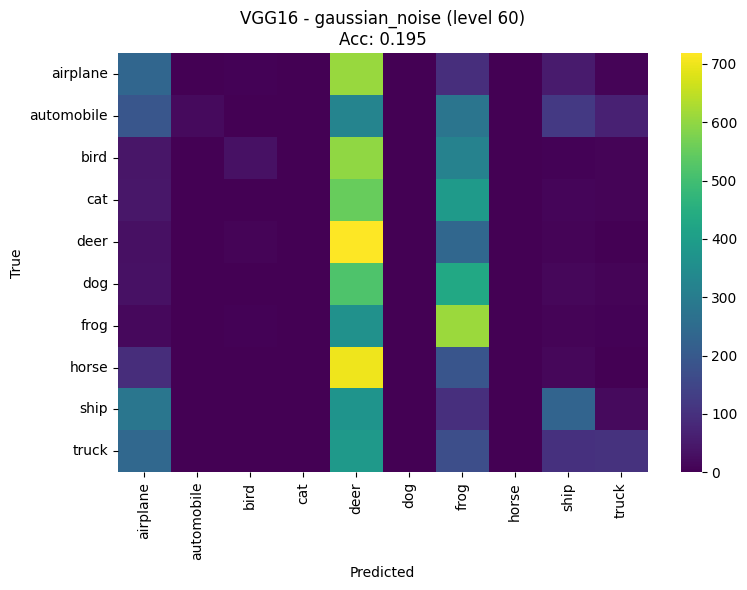

airplane: F1 = 0.212
automobile: F1 = 0.037
bird: F1 = 0.061
cat: F1 = 0.000
deer: F1 = 0.234
dog: F1 = 0.000
frog: F1 = 0.320
horse: F1 = 0.004
ship: F1 = 0.295
truck: F1 = 0.167

Running corruption: gaussian_blur


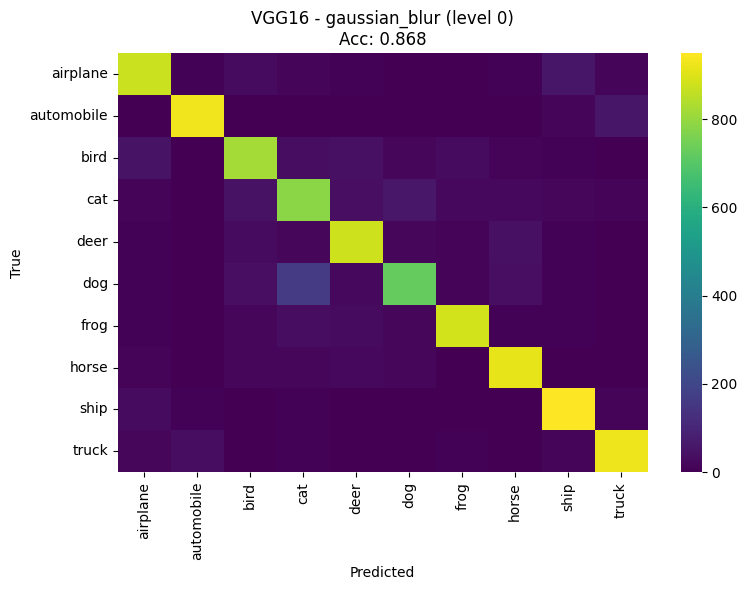

airplane: F1 = 0.870
automobile: F1 = 0.936
bird: F1 = 0.823
cat: F1 = 0.756
deer: F1 = 0.866
dog: F1 = 0.785
frog: F1 = 0.903
horse: F1 = 0.898
ship: F1 = 0.920
truck: F1 = 0.918


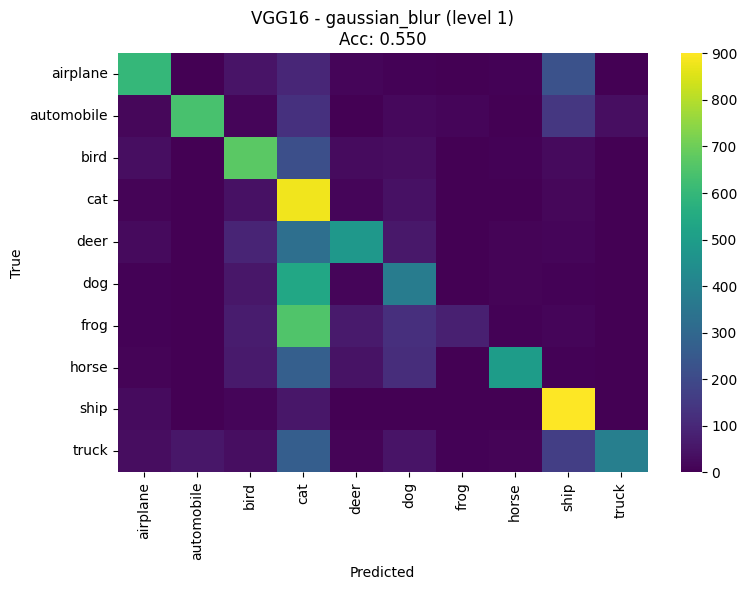

airplane: F1 = 0.681
automobile: F1 = 0.753
bird: F1 = 0.640
cat: F1 = 0.398
deer: F1 = 0.579
dog: F1 = 0.414
frog: F1 = 0.144
horse: F1 = 0.644
ship: F1 = 0.718
truck: F1 = 0.541


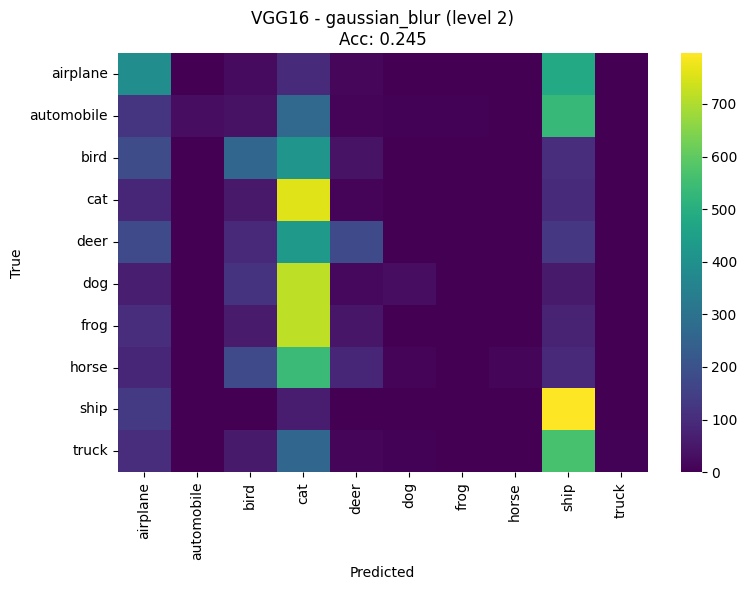

airplane: F1 = 0.317
automobile: F1 = 0.049
bird: F1 = 0.281
cat: F1 = 0.288
deer: F1 = 0.256
dog: F1 = 0.050
frog: F1 = 0.002
horse: F1 = 0.020
ship: F1 = 0.407
truck: F1 = 0.008


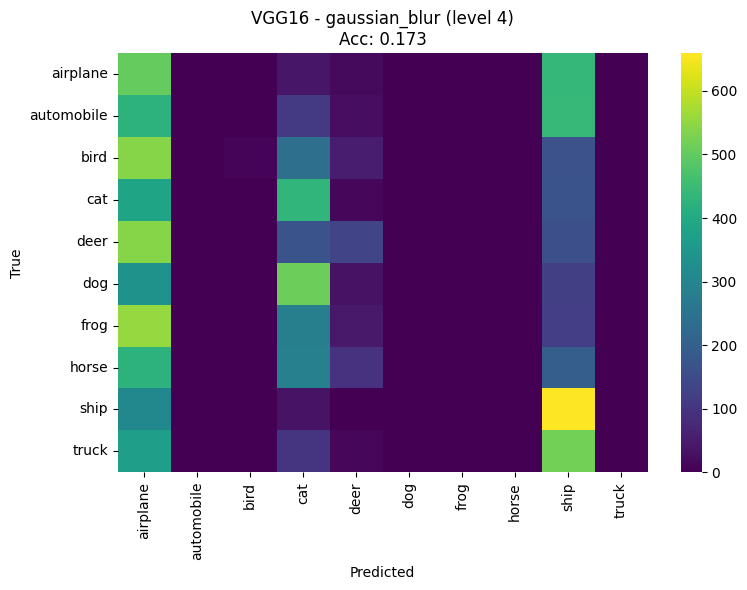

airplane: F1 = 0.187
automobile: F1 = 0.000
bird: F1 = 0.012
cat: F1 = 0.270
deer: F1 = 0.188
dog: F1 = 0.000
frog: F1 = 0.000
horse: F1 = 0.000
ship: F1 = 0.330
truck: F1 = 0.000


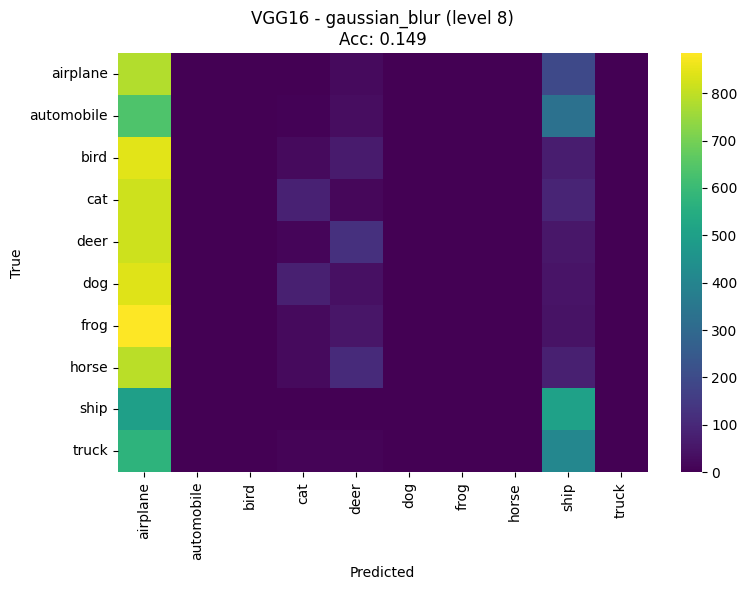

airplane: F1 = 0.185
automobile: F1 = 0.000
bird: F1 = 0.000
cat: F1 = 0.127
deer: F1 = 0.168
dog: F1 = 0.000
frog: F1 = 0.000
horse: F1 = 0.000
ship: F1 = 0.357
truck: F1 = 0.000

Running corruption: jpeg_compression


ValueError: Unknown corruption jpeg_compression

In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from torchvision import transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# -----------------------
# Preprocessing transform
# -----------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

def preprocess_batch(img_batch_np):
    """Convert numpy batch to torch tensor batch, normalized"""
    tensor_list = [transform(Image.fromarray(img)).unsqueeze(0) for img in img_batch_np]
    return torch.cat(tensor_list, dim=0).to(device)

# -----------------------
# Safe model loading
# -----------------------
def load_model_state(model, path):
    state_dict = torch.load(path, map_location=device)
    new_state_dict = {}
    for k, v in state_dict.items():
        new_key = k.replace('module.', '')  # strip DataParallel prefix if exists
        new_state_dict[new_key] = v
    model.load_state_dict(new_state_dict)
    return model

# -----------------------
# Create proper model
# -----------------------
def create_model_by_name(model_name):
    import torchvision.models as models
    if "resnet" in model_name.lower():
        return models.resnet18(weights=None, num_classes=10)
    elif "vgg" in model_name.lower():
        return models.vgg16(weights=None, num_classes=10)
    elif "efficientnet" in model_name.lower():
        return models.efficientnet_b0(weights=None, num_classes=10)
    else:
        raise ValueError(f"Unknown model {model_name}")

# -----------------------
# Evaluation loop
# -----------------------
all_model_results = {}

model_paths = {
    "VGG16": "/kaggle/working/model_results/best_VGG16.pth",
    "ResNet18": "/kaggle/working/model_results/best_ResNet18.pth",
    "EfficientNet_B0": "/kaggle/working/model_results/best_EfficientNet_B0.pth"
}

batch_size = 128

for model_name, model_path in model_paths.items():
    print(f"\n=== Evaluating {model_name} on TEST set ===")
    
    model = create_model_by_name(model_name)
    model = load_model_state(model, model_path)
    model.to(device)
    model.eval()
    
    model_results = {}
    
    for corruption_name, levels in corruption_params.items():
        print(f"\nRunning corruption: {corruption_name}")
        corruption_results = {}
        
        for level in levels:
            # Apply corruption
            corrupted_images_np = apply_corruption(test_images, corruption_name, level)
            corrupted_images = preprocess_batch(corrupted_images_np)
            
            # Predictions
            preds = []
            with torch.no_grad():
                for i in range(0, len(corrupted_images), batch_size):
                    batch = corrupted_images[i:i+batch_size]
                    outputs = model(batch)
                    preds.extend(outputs.argmax(dim=1).cpu().numpy())
            
            # Metrics
            cm = confusion_matrix(test_labels, preds)
            f1 = f1_score(test_labels, preds, average=None)  # per-class
            acc = accuracy_score(test_labels, preds)
            
            # Store results
            corruption_results[level] = {
                "confusion_matrix": cm,
                "f1_per_class": f1,
                "accuracy": acc
            }
            
            # Plot confusion matrix heatmap
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=False, fmt='d', cmap='viridis',
                        xticklabels=class_names, yticklabels=class_names)
            plt.title(f"{model_name} - {corruption_name} (level {level})\nAcc: {acc:.3f}")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.tight_layout()
            plt.show()
            
            # Optional: print class-wise F1
            for i, cname in enumerate(class_names):
                print(f"{cname}: F1 = {f1[i]:.3f}")
        
        model_results[corruption_name] = corruption_results
    
    all_model_results[model_name] = model_results
